In [1]:
import numpy as np
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from nltk.stem.porter import PorterStemmer
import collections
from tqdm import tqdm_notebook as tqdm
from networkx.algorithms import approximation

### Reference Code

In [2]:
def load_data_2(dataset): #Includes fixing isolated nodes for y
    
    # load the data: x, tx, allx, graph
    dataset = 'citeseer'
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../gae/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../gae/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)

        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        ty_extended = sp.lil_matrix((len(test_idx_range_full), y.shape[1]))

        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        ty_extended[test_idx_range-min(test_idx_range), :] = ty

        tx = tx_extended
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    y        = sp.vstack((ally, ty)).tolil()
    
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    
    return adj, features, ty, y, x

### Read AMiner Dataset and Build Adjascency Matrix and Features

In [3]:
paper_author = pd.read_csv('data_aminer/paper_author.txt', sep = '\t', header = None, names = ['paper', 'author'])
paper_conf   = pd.read_csv('data_aminer/paper_conf.txt', sep = '\t', header = None, names = ['paper', 'conf'])

In [2]:
id_paper = pd.read_csv('data_aminer/paper.txt', sep = '\t', header = None, names = ['id', 'paper'])
#id_author = pd.read_csv('data_aminer/id_author.txt', sep = '\t', header = None, names = ['id', 'author'])
#id_conference =  pd.read_csv('data_aminer/id_conf.txt', sep = '\t', header = None, names = ['id', 'conference'])

In [5]:
paper_author['paper_node'] = 'p' + paper_author['paper'].astype(str)
paper_author['author_node'] = 'a' + paper_author['author'].astype(str)

paper_conf['paper_node'] = 'p' + paper_conf['paper'].astype(str)
paper_conf['conf_node'] = 'c' + paper_conf['conf'].astype(str)


In [6]:
## Search for Connference

id_author[id_author['author'].str.contains('FrankThomsonLeighton')]

,id,author
1442893,39369,aFrankThomsonLeighton


In [7]:
aminer_edgelist = pd.DataFrame(columns = ['to', 'from'])

aminer_edgelist['to'] = list(paper_author['paper_node']) + list(paper_conf['paper_node'])
aminer_edgelist['from'] = list(paper_author['author_node']) + list(paper_conf['conf_node'])

In [8]:
aminer_graph = nx.from_pandas_edgelist(aminer_edgelist, source = 'from', target = 'to')

In [9]:
len(aminer_graph.edges)

12518010

In [10]:
len(aminer_graph.nodes)

4891819

### Plot Degree Distribution

In [9]:
degree_sequence = sorted([d for n, d in aminer_graph.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

degree_dataframe = pd.DataFrame({'degree': deg, 'count': cnt})
degree_dataframe = degree_dataframe.set_index('degree', drop = True)

In [10]:
high_degree_dataframe = degree_dataframe[degree_dataframe['count'] > 100]

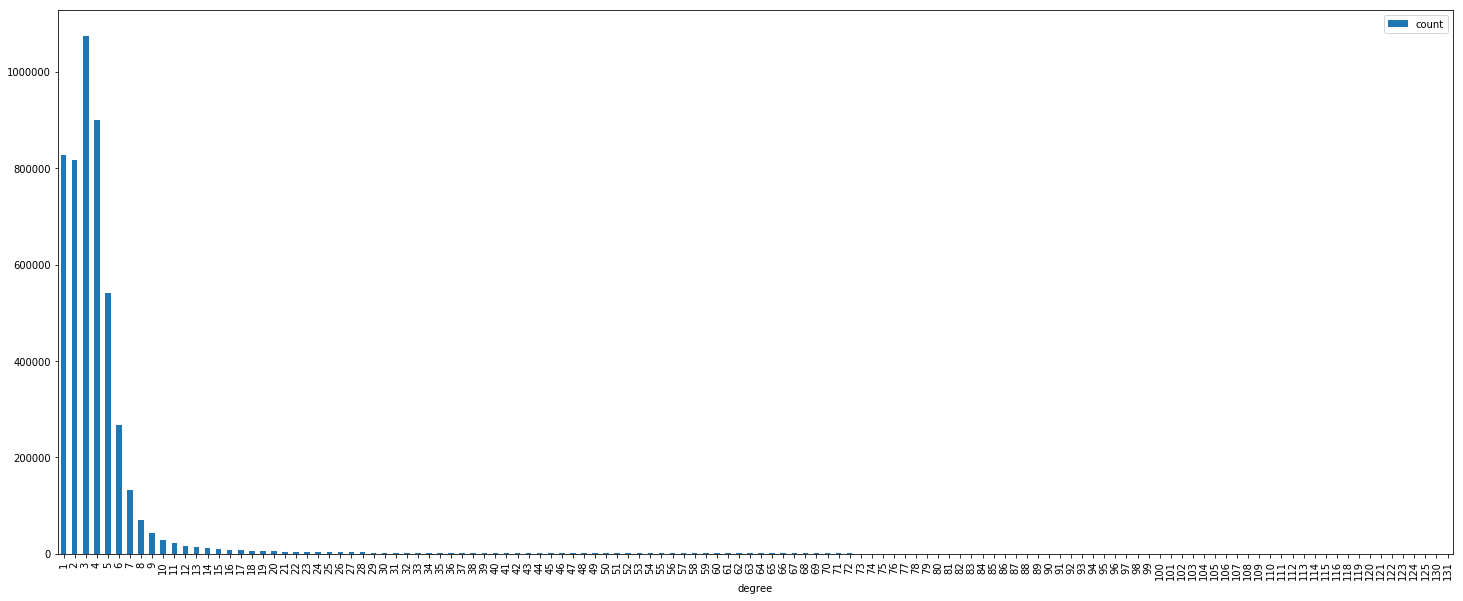

In [11]:
binned  = high_degree_dataframe.groupby(high_degree_dataframe.index // 1).sum()
binned.plot.bar(figsize=(25,10))

### Remove low degree nodes from graph

In [13]:
node_degree_df = pd.DataFrame(aminer_graph.degree(), columns = ['node', 'degree']).set_index('node', drop = True)

In [14]:
low_degree_dataframe = node_degree_df[node_degree_df['degree'] < 20]

len(low_degree_dataframe)/len(aminer_graph.nodes)

0.9807169889155751

In [15]:
low_degree_set = set(list(low_degree_dataframe.index))
aminer_graph.remove_nodes_from([n for n in tqdm(aminer_graph) if n in low_degree_set])

In [16]:
len(aminer_graph.nodes)

94329

In [17]:
len(aminer_graph.edges)

13101

### Create adjascency matrix

In [18]:
aminer_adj = nx.adjacency_matrix(aminer_graph)

In [19]:
aminer_adj

<94329x94329 sparse matrix of type '<class 'numpy.int64'>'
	with 26202 stored elements in Compressed Sparse Row format>

### Create feature matrix

In [3]:
# DF parallelization chunk

from multiprocessing import  Pool
from functools import partial
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
#tqdm_notebook.pandas()

def parallelize(data, func, num_of_processes=11):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)
    #return data_subset.progress_apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=11):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

#Instead of df.apply(some_func, axis=1)
#Use parallelize_on_rows(df, some_func)

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/omai.r/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/omai.r/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#stemmer = PorterStemmer()
#id_paper['paper_tokens'] = id_paper['paper'].apply(lambda x: [w for w in word_tokenize(str(x).lower()) if (w not in stop) and (w.isalpha())])
#id_paper['paper_tokens'] = id_paper['paper_tokens'].apply(lambda x: [set(stemmer.stem(w)) for w in x])

In [ ]:
def tokenize_send_to_pool(x, axis):
    stop = set(stopwords.words('english'))
    return [w for w in word_tokenize(str(x).lower()) if (w not in stop) and (w.isalpha())]

id_paper['paper_tokens'] = parallelize_on_rows(id_paper['paper'], tokenize_send_to_pool)

In [5]:
id_paper['paper_tokens']

0          [parallel, integer, sorting, simulation, among...
1                           [pattern, matching, trees, nets]
2                      [problems, simplified, tree, schemas]
3             [power, chain, rules, context, free, grammars]
4          [schnelle, multiplikation, von, polynomen, uum...
                                 ...                        
3192139    [comparison, proximity, measures, topological,...
3192140         [summarizing, querying, logs, olap, queries]
3192141    [comparing, two, discriminant, probabilistic, ...
3192142    [bayesian, criterion, evaluating, robustness, ...
3192143             [mining, sequential, patterns, approach]
Name: paper_tokens, Length: 3192144, dtype: object

In [6]:
features_tokenized = set()

for i in id_paper['paper_tokens']:
    features_tokenized.update(i)

onehot_encoder = OneHotEncoder(sparse=True)
onehot_encoder.fit(np.array(list(features_tokenized)).reshape(-1, 1))

def one_hot_to_pool(x, axis):

    if len(x) != 0:
        return np.array(sum(onehot_encoder.transform(np.array(x).reshape(-1,1)).todense()))[0]
    else:
        return np.zeros((1,len(features_tokenized)))
    
#id_paper['one_hot'] = parallelize_on_rows(id_paper['paper_tokens'], tokenize_send_to_pool)

In [8]:
id_paper['paper_onehot'] = parallelize_on_rows(id_paper['paper_tokens'], one_hot_to_pool)

TypeError: data type not understood

In [ ]:
id_paper['paper_onehot'] = parallelize_on_rows(id_paper['paper_tokens'], one_hot_to_pool)

In [90]:
np.array(sum(onehot_encoder.transform(np.array(id_paper['paper_tokens'][1]).reshape(-1, 1)).todense()))[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [151]:
onehot_encoder.transform(np.array(id_paper['paper_tokens'][1]).reshape(-1, 1)).todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [184]:
paper_onehot = list()
for row in tqdm(id_paper['paper_tokens'][:5]): 
    if len(row) != 0:
        paper_onehot.append(sum(onehot_encoder.transform(np.array(row).reshape(-1,1)).todense()))

In [185]:
paper_onehot

[matrix([[0., 0., 0., ..., 0., 0., 0.]]),
 matrix([[0., 0., 0., ..., 0., 0., 0.]]),
 matrix([[0., 0., 0., ..., 0., 0., 0.]]),
 matrix([[0., 0., 0., ..., 0., 0., 0.]]),
 matrix([[0., 0., 0., ..., 0., 0., 0.]])]

In [187]:
paper_onehot = id_paper['paper_tokens'][35:40].apply(lambda x: np.sum(onehot_encoder.transform(np.array(x).reshape(-1,1)).todense(), axis = 0))

In [209]:
len(np.array(paper_onehot[35])[0])

271305

In [213]:
np.zeros((1,271305))

array([[0., 0., 0., ..., 0., 0., 0.]])

In [215]:
len(features_tokenized)

271305